In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from lightkurve import search_lightcurvefile
from requests.exceptions import HTTPError
from astropy.coordinates import SkyCoord
from astroquery.mast import Tesscut
from astropy.timeseries import LombScargle
from photutils import CircularAperture, aperture_photometry

import astropy.units as u

table = Table.read('../data/gagne2018xmatchTIC.vot').group_by('Assoc')

/Users/brettmorris/git/astropy/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Star index: 0


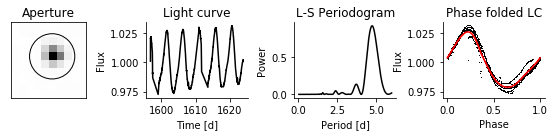

Star index: 2


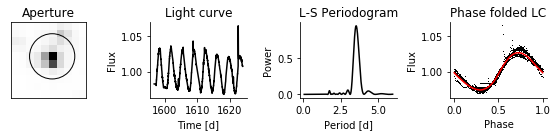

Star index: 3


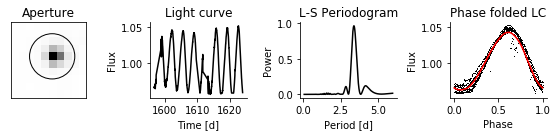

Star index: 5


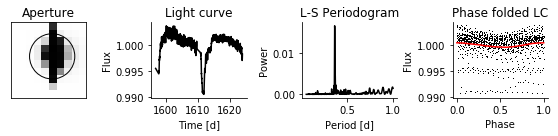

Star index: 6


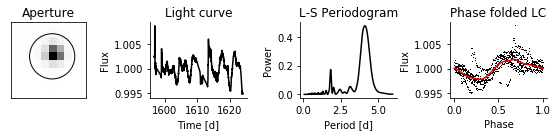

Star index: 7


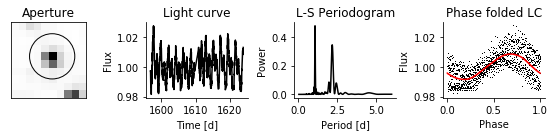

Star index: 8


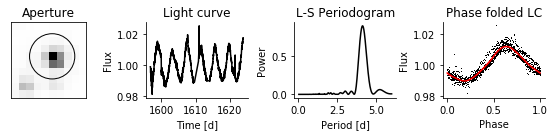

Star index: 9


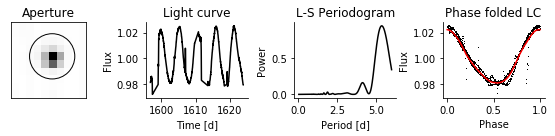

Star index: 10


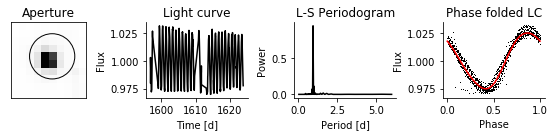

Star index: 11


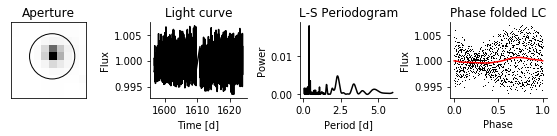

Star index: 12


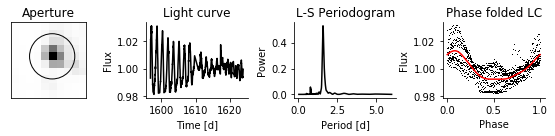

Star index: 13


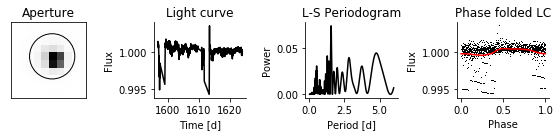

Star index: 14


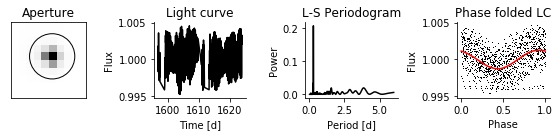

Star index: 15


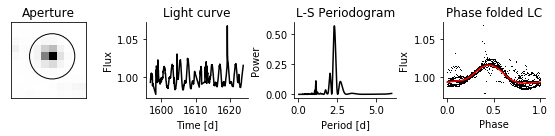

Star index: 16


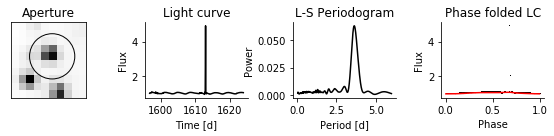

Star index: 17


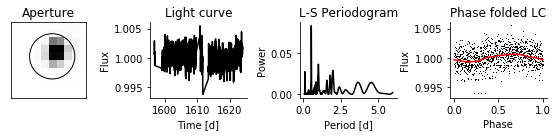

Star index: 18


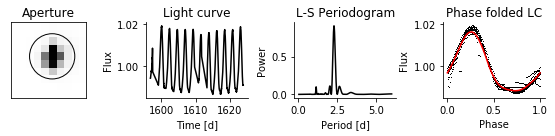

Star index: 19


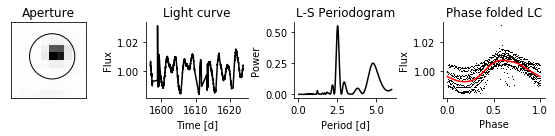

Star index: 20


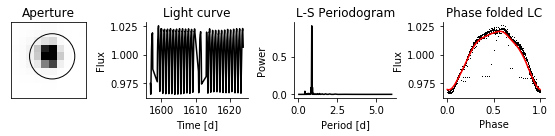

Star index: 21


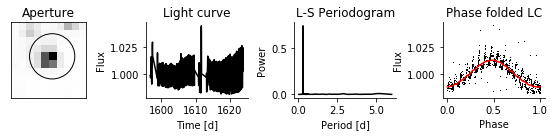

Star index: 22


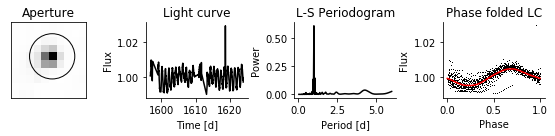

Star index: 23


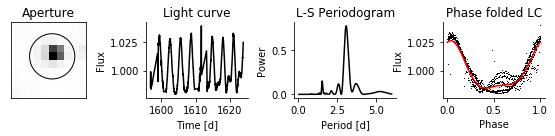

Star index: 25


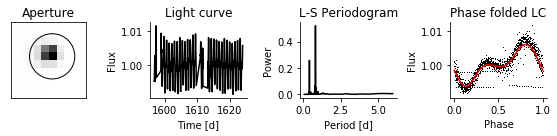

Star index: 27


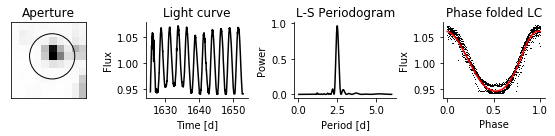

Star index: 32


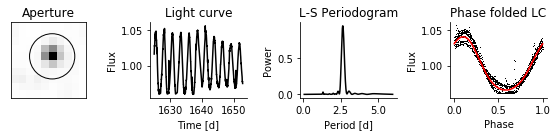

Star index: 33


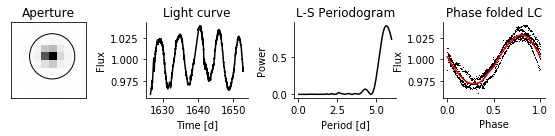

Star index: 34


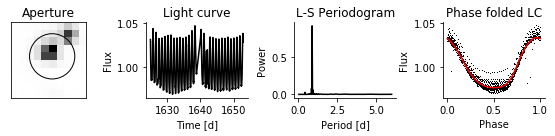

Star index: 35


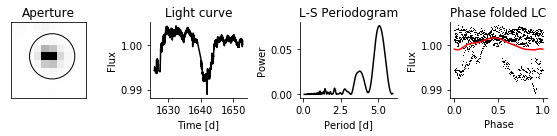

Star index: 36


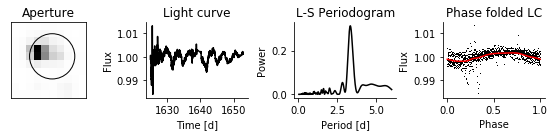

Star index: 38


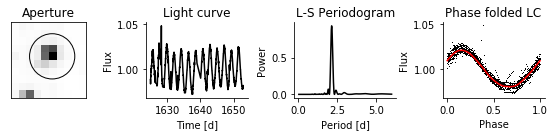

Star index: 39


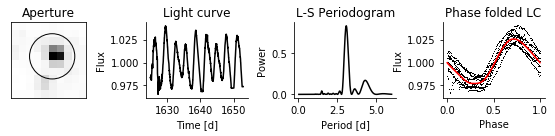

Star index: 40


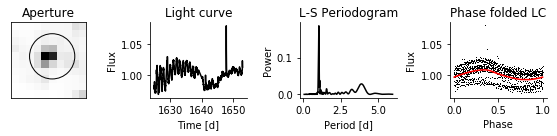

Star index: 41


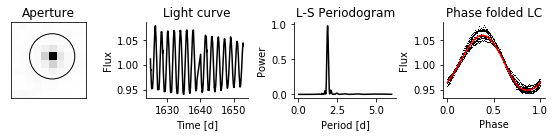

Star index: 42


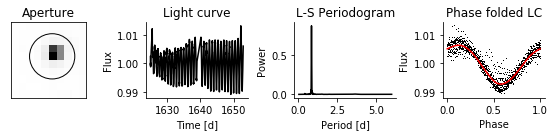

In [34]:
from astroquery.mast import Conf
from scipy.ndimage import gaussian_filter1d

Conf.timeout = 1

size = 10

smoothed_amps_ucl = []

ucl = table[(table['M_'] > 0.6 * u.M_sun) & (table['Assoc'] == b'UCL')] 
ucl_periods = []

coords = SkyCoord(ucl['_RAJ2000'], ucl['_DEJ2000'])
binary_list = [1, 24]
limit_pmax_list = [5]
save_list = [41]

for i, coord in enumerate(coords):

    cutouts = Tesscut.get_cutouts(coord, size=size)

    if len(cutouts) > 0:
        times = cutouts[0][1].data['TIME']
        flux = cutouts[0][1].data['FLUX'].sum(axis=(1, 2)) - (size**2) * np.median(cutouts[0][1].data['FLUX'], axis=(1, 2))
        flux /= np.nanmedian(flux)

        mask = (flux > 0.9) & (flux < 1.1)

        ap = CircularAperture([5, 5], 3)
        fluxes = []
        
        for j, image in enumerate(cutouts[0][1].data['FLUX']):
            if mask[j]:
                f = aperture_photometry(image - np.median(image), ap)

                fluxes.append(f['aperture_sum'].data[0])

        fluxes = np.array(fluxes)
        
        dip_mask = fluxes > np.percentile(fluxes, 5)
        
        fluxes = np.interp(times[mask], times[mask][dip_mask], fluxes[dip_mask])
        
        detrended = fluxes / np.polyval(np.polyfit(times[mask] - times[mask].mean(), fluxes, 2), times[mask] - times[mask].mean())
        
        if len(detrended) > 100 and i not in binary_list:
            print('Star index:', i)
            # L-S periodogram
            ls = LombScargle(times[mask] * u.day, detrended)
            periods = np.linspace(0.05, 
                                  6 if i not in limit_pmax_list else 1, 
                                  1000) * u.day
            freq = 1/periods
            power = ls.power(freq)
            best_period = periods[power.argmax()].to(u.day).value

            phases = (((times[mask] - 0) % best_period) / best_period)

            smoothed = gaussian_filter1d(detrended[np.argsort(phases)], 50, mode='wrap')

            fig, ax = plt.subplots(1, 4, figsize=(8, 2))
            ax[0].imshow(cutouts[0][1].data['FLUX'].sum(0), origin='lower', cmap=plt.cm.Greys)
            ap.plot(axes=ax[0], color='k')
            ax[0].set_title('Aperture')
            ax[0].set_xticks([])
            ax[0].set_yticks([])
            
            ax[1].plot(times[mask], detrended, 'k')
            ax[1].set(title='Light curve', xlabel='Time [d]', ylabel='Flux')
            
            ax[2].plot(periods, power, 'k')
            ax[2].set(title='L-S Periodogram', xlabel='Period [d]', ylabel='Power')
            
            ax[3].plot(phases, detrended, ',k')
            ax[3].plot(phases[np.argsort(phases)], smoothed, 'r')
            ax[3].set(title='Phase folded LC', xlabel='Phase', ylabel='Flux')
            
            for axis in ax[1:]:
                for s in ['right', 'top']: 
                    axis.spines[s].set_visible(False)
            
            plt.tight_layout(w_pad=0.2)

            if i in save_list: 
                plt.savefig('plots/ucl.pdf', bbox_inches='tight')
            
            plt.show()

            smoothed_amps_ucl.append(smoothed.ptp())
            ucl_periods.append(best_period)

In [36]:
np.save('data/ucl_amps.npy', smoothed_amps_ucl)
np.save('data/ucl_pers.npy', ucl_periods)